# Overview

Several areas of Earth with large accumulations of oil and gas also have huge deposits of salt below the surface.

But unfortunately, knowing where large salt deposits are precisely is very difficult. Professional seismic imaging still requires expert human interpretation of salt bodies. This leads to very subjective, highly variable renderings. More alarmingly, it leads to potentially dangerous situations for oil and gas company drillers.

Our goal is to build an algorithm that automatically and accurately identifies if a subsurface target is salt or not.


In [3]:
%matplotlib inline
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")


import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
import os
import pandas as pd
import skimage.feature
from skimage.transform import resize


from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization, UpSampling2D,Concatenate, Activation,Add
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from tqdm import tqdm_notebook

from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


In [2]:
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.6
# session = tf.Session(config=config)

## Data Exploration

Data is organized in several files and folders

In [ ]:
!ls ../data/train/

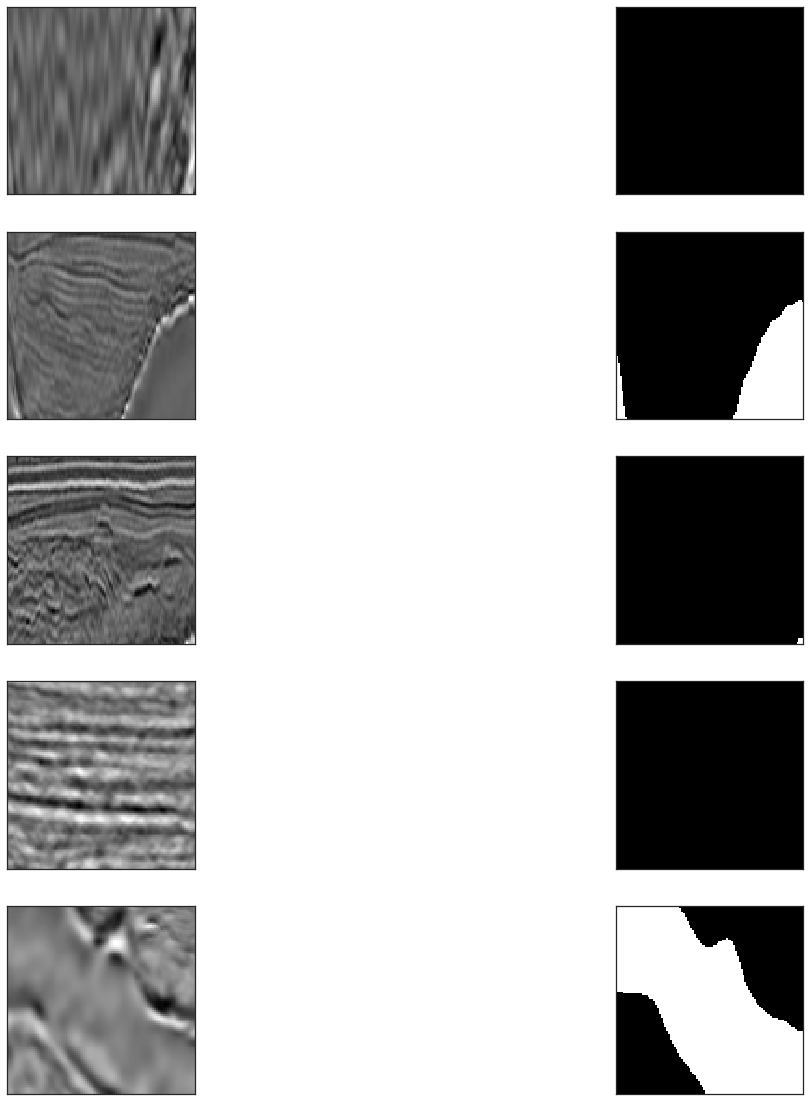

In [2]:
#plotting 
img_name = ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','0a1742c740']
img_path = []

for name in img_name:
    img_path.append('../data/train/images/' + name + '.png')
    img_path.append('../data/train/masks/' + name + '.png')

fig, imgGrid = plt.subplots(nrows=5, ncols=2, figsize=(20,20));
imgGrid = imgGrid.ravel() #Return a contiguous flattened array.
for i in range(len(imgGrid)):
    img =  mpimg.imread(img_path[i])
    imgGrid[i].imshow(img, cmap='gray')
    imgGrid[i].axes.get_xaxis().set_visible(False)
    imgGrid[i].axes.get_yaxis().set_visible(False)
 #plt.tight_layout(pad=0, w_pad=-30, h_pad=0)

In [3]:
#Image Size\
img.shape

(101, 101)

We need to get our data into a shape that works for U-Nets. That means, it should be a power of 2. Let's do it quick and dirty for now, but eventually, consider aliasing and all that fun.

In [4]:
img_size_ori = 101
img_size_target = 198

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

## Loading of training/testing ids and depths

In [4]:
train_df = pd.read_csv("../data/train/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../data/train/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

## Read images and masks

Load the images and masks into the DataFrame and divide the pixel values by 255.

In [5]:
train_df["images"] = [np.array(load_img("../data/train/images/{}.png".format(idx))) / 255 for idx in tqdm_notebook(train_df.index)]

In [6]:
train_df["masks"] = [np.array(load_img("../data/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

## Calculating the salt coverage and salt coverage classes¶

Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only. Plotting the distribution of coverages and coverage classes, and the class against the raw coverage

In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [8]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Coverage class')

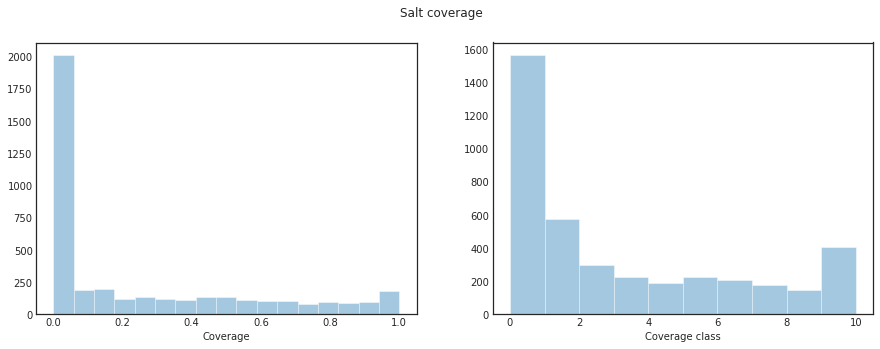

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

## Plotting the depth distributions

Separatelty plotting the depth distributions for the training and the testing data.

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Depth distribution')

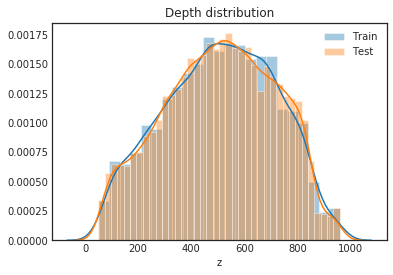

In [10]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

## Show some example images

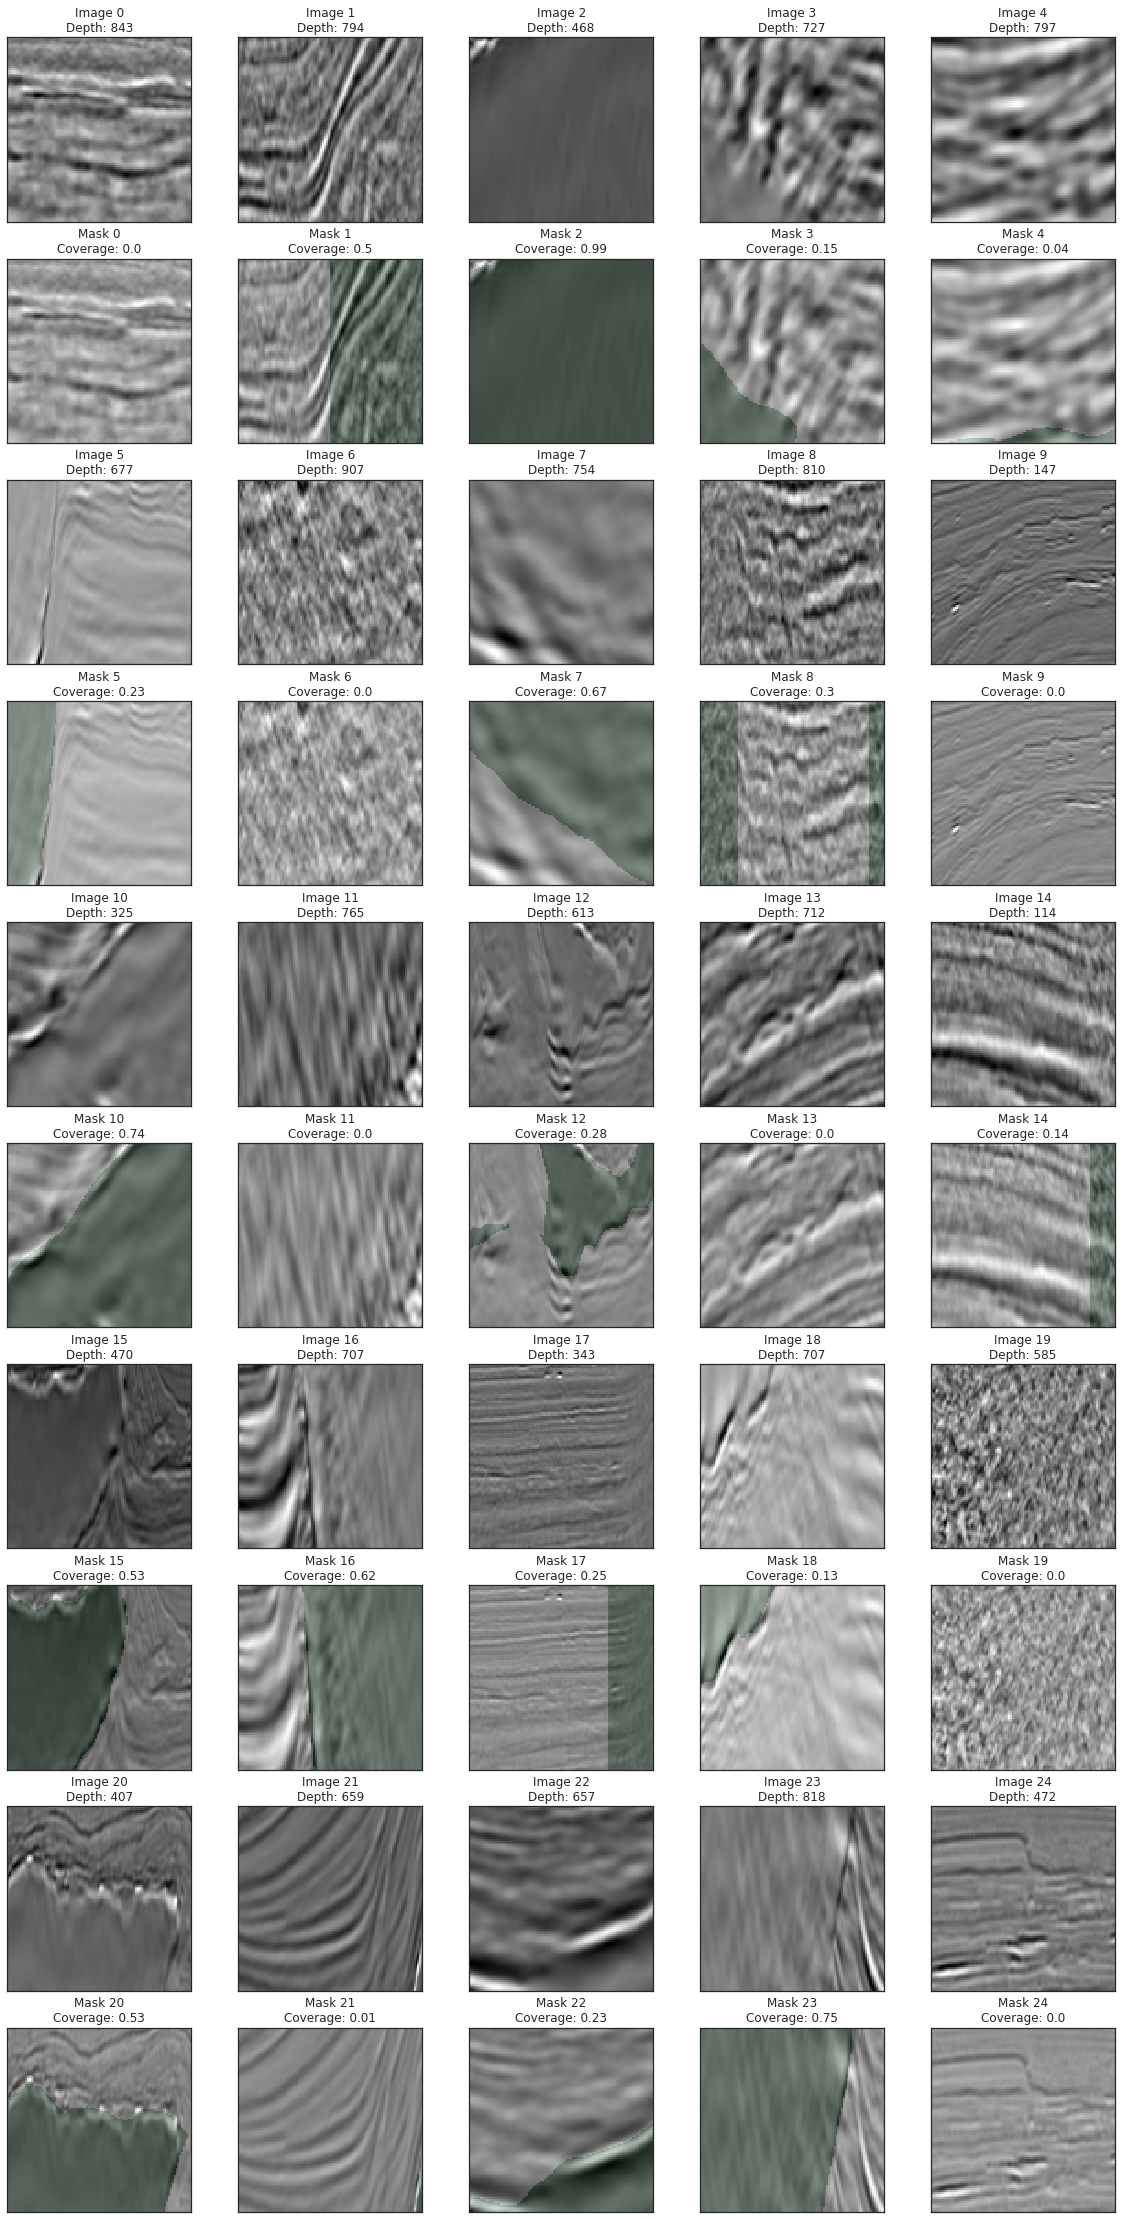

In [11]:
max_images = 25
grid_width = 5
grid_height = int(max_images / grid_width)*2
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax_image = axs[int(i / grid_width)*2, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image {0}\nDepth: {1}".format(i, train_df.loc[idx].z))
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*2+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.2, cmap="Greens")
    ax_mask.set_title("Mask {0}\nCoverage: {1}".format(i,  round(train_df.loc[idx].coverage, 2)))
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])

## Create train/validation split stratified by salt coverage¶
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [12]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 3), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


## Build Model

In [5]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [5]:
#Build model for 197 input. The problem was upscale
def build_model(input_layer, start_neurons, base_model, DropoutRatio = 0.5):

    # Get Resnet
    #resnet50_model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape= input_layer, pooling=None)
    
    base_model.layers.pop()
    
    for layer in base_model.layers:#[:173]:
        layer.trainable = False

#     # Creating dictionary that maps layer names to the layers
#     layers = dict([(layer.name, layer) for layer in base_model.layers])

#     conv1 = layers['activation_148'].output
#     conv2 = layers['activation_157'].output
#     conv3 = layers['activation_169'].output
#     conv4 = layers['activation_187'].output
#     convm = layers['activation_196'].output
    
    
    conv1 = base_model.layers[3].output
    conv2 = base_model.layers[36].output
    conv3 = base_model.layers[78].output
    conv4 = base_model.layers[140].output
    convm = base_model.layers[172].output

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 16, (7, 7), strides=(1, 1), padding="valid")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same")(uconv4)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 8, (13, 13), strides=(1, 1), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same")(uconv3)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 4, (25, 25), strides=(1, 1), padding="valid")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same")(uconv2)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation='relu', padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation='relu', padding="same")(uconv1)
#     uconv1 = residual_block(uconv1,start_neurons * 1)
#     uconv1 = residual_block(uconv1,start_neurons * 1, True)
    


    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv0 = Conv2DTranspose(start_neurons * 1, (1, 1), strides=(2, 2), padding="valid")(uconv1)
    #uconv1 = concatenate([deconv1, conv1])
    
    uconv0 = Dropout(DropoutRatio)(deconv0 )
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation='relu', padding="same")(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation='relu', padding="same")(uconv0)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1, True)    
    
    
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv0)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    model = Model(base_model.input, output_layer)
    return model

In [4]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [5]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [6]:
# model
# input_layer = Input((img_size_target, img_size_target, 1))
# output_layer = build_model(input_layer, 16,0.5)

# model1 = Model(input_layer, output_layer)
#img_size_target = 198
input_layer = (img_size_target, img_size_target, 3)
resnet50_model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape= input_layer, pooling=None, )



In [7]:
model1 = build_model(input_layer, 64,resnet50_model, 0.5)

In [19]:

c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 198, 198, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 99, 99, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 99, 99, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 99, 64)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Data augmentation

In [21]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

Text(0.5,0.98,'Top row: original images, bottom row: augmented images')

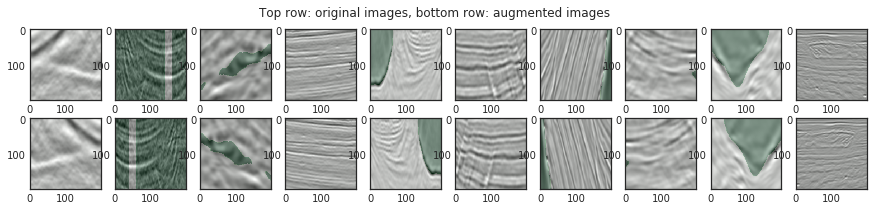

In [22]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

In [23]:
#early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model",monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 5
batch_size = 16
history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/5


ResourceExhaustedError: OOM when allocating tensor with shape[16,64,198,198] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_transpose_5/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/conv2d_transpose_5/conv2d_transpose_grad/Conv2D"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_transpose_5/conv2d_transpose-0-VecPermuteNHWCToNCHW-LayoutOptimizer, conv2d_transpose_5/kernel/read, activation_69/Relu)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: metrics/my_iou_metric/Mean/_3063 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17671_metrics/my_iou_metric/Mean", tensor_type=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d_transpose_5/conv2d_transpose', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-01f813d84d94>", line 1, in <module>
    model1 = build_model(input_layer, 64,resnet50_model, 0.5)
  File "<ipython-input-14-6f7317c4fa81>", line 69, in build_model
    deconv0 = Conv2DTranspose(start_neurons * 1, (1, 1), strides=(2, 2), padding="valid")(uconv1)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/layers/convolutional.py", line 774, in call
    data_format=self.data_format)
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 3238, in conv2d_transpose
    data_format=tf_data_format)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 1254, in conv2d_transpose
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 1228, in conv2d_backprop_input
    dilations=dilations, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[16,64,198,198] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_transpose_5/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/conv2d_transpose_5/conv2d_transpose_grad/Conv2D"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_transpose_5/conv2d_transpose-0-VecPermuteNHWCToNCHW-LayoutOptimizer, conv2d_transpose_5/kernel/read, activation_69/Relu)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: metrics/my_iou_metric/Mean/_3063 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17671_metrics/my_iou_metric/Mean", tensor_type=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
#early_stopping = EarlyStopping(patience=10, verbose=1)
#model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
#reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000005, verbose=1)

#epochs = 200
#batch_size = 16

#history = model.fit(x_train, y_train,
#                    validation_data=[x_valid, y_valid], 
#                    epochs=epochs,
#                    batch_size=batch_size,
#                   callbacks=[early_stopping, model_checkpoint, reduce_lr])

In [ ]:
model1 = load_model("./keras.model",custom_objects={'my_iou_metric': my_iou_metric})
# remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input

output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr = 0.01)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

#model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model",monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
epochs = 50
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr,early_stopping], 
                    verbose=2)

In [ ]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [ ]:
#fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
#ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
#ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
#ax_loss.legend()
#ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
#ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
#ax_acc.legend()

## Predict the validation set to do a sanity check

Again plot some sample images including the predictions.

In [ ]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
mask_valid = np.array([downsample(x) for x in y_valid])

## Scoring

Score the model and do a threshold optimization by the best IoU.

In [ ]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(mask_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [ ]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

In [ ]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

## Sanity check with adjusted threshold

Again some sample images with the adjusted threshold.

In [ ]:
max_images = 30
grid_width = 5
grid_height = int(max_images / grid_width)*3
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for i, idx in enumerate(ids_valid[:max_images]):
    #print(idx)
    img = downsample(np.squeeze(x_valid[i]))
    mask = np.squeeze(mask_valid[i])
    pred = np.squeeze(preds_valid[i]>threshold_best)
    ax_image = axs[int(i / grid_width)*3, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image {0}\nDepth: {1}".format(idx, train_df.loc[idx].z))
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*3+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.9, cmap="Greens")
    ax_mask.set_title("Mask {0}\nCoverage: {1}".format(idx,  round(train_df.loc[idx].coverage, 2)))
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])
    ax_pred = axs[int(i / grid_width)*3+2, i % grid_width]
    ax_pred.imshow(img, cmap="Greys")
    ax_pred.imshow(pred, alpha=0.9, cmap="Blues")
    coverage_pred = np.sum(pred) / pow(img_size_ori, 2)
    ax_pred.set_title("Predict {0}\nCoverage: {1}".format(idx,  round(coverage_pred, 2)))
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

## Submission

Load, predict and submit the test image predictions.

In [ ]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [ ]:
x_test = np.array([upsample(np.array(load_img("../data/test/images/{}.png".format(idx)))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [ ]:
preds_test = model.predict(x_test)

In [ ]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [ ]:
import datetime


sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
print('Submission output to: sub-{}.csv'.format(timestamp))
sub.to_csv("sub-{}.csv".format(timestamp))